In [1]:
import earthchem
earthchem.__version__

'0.0.2+2.g5fe1c0f.dirty'

Make a rest client

In [2]:
from earthchem.query import RESTClientQuery

q = RESTClientQuery(author='klump')
q.url

'http://ecp.iedadata.org/restsearchservice?outputtype=json&author=klump'

How many records have we found?

In [3]:
q.count()

0

In [4]:
q.dataframe()

Didn't find any records, returning None


Let's try another author

In [5]:
q = RESTClientQuery(author='barnes')
q.count()

4902

Get the first 50 records

In [6]:
df = q.dataframe()
df.head()

,al2o3,author,cao,cl,composition,feot,journal,k,k2o,latitude,...,mno,na2o,p2o5,rock_name,sample_id,sio2,source,tio2,title,type
0,NaN,"BARNES, J. D.; STRAUB, S. M.",NaN,647.0,unknown,NaN,CHEM. GEOL.,NaN,NaN,18.0448,...,NaN,NaN,NaN,not-given,64DS,NaN,GEOROC,NaN,CHLORINE STABLE ISOTOPE VARIATIONS IN IZU BONI...,volcanic
1,13.3,"BARNES, J. D.; STRAUB, S. M.",9.37,560.0,unknown,12.63,CHEM. GEOL.,NaN,0.30,30.8610,...,0.31,2.20,0.10,not-given,125-782A-29X3-42-46,48.47,GEOROC,1.02,CHLORINE STABLE ISOTOPE VARIATIONS IN IZU BONI...,volcanic
2,14.2,"BARNES, J. D.; STRAUB, S. M.",8.84,960.0,unknown,10.78,CHEM. GEOL.,NaN,0.33,30.8610,...,0.38,2.60,0.10,not-given,125-782A-29X3-42-46,52.00,GEOROC,0.86,CHLORINE STABLE ISOTOPE VARIATIONS IN IZU BONI...,volcanic
3,13.6,"BARNES, J. D.; STRAUB, S. M.",9.30,1170.0,unknown,12.43,CHEM. GEOL.,NaN,0.26,30.8610,...,0.22,2.27,0.11,not-given,125-782A-29X3-42-46,49.72,GEOROC,0.98,CHLORINE STABLE ISOTOPE VARIATIONS IN IZU BONI...,volcanic
4,14.3,"BARNES, J. D.; STRAUB, S. M.",6.39,1870.0,unknown,8.02,CHEM. GEOL.,NaN,0.64,30.8610,...,0.22,3.77,0.15,not-given,125-782A-29X3-42-46,57.82,GEOROC,0.83,CHLORINE STABLE ISOTOPE VARIATIONS IN IZU BONI...,volcanic


In [18]:
from collections import defaultdict

In [19]:
stuff = defaultdict(list)

In [21]:
for k, c in df.items():
    stuff[str(c.dtype)].append(k)

In [22]:
stuff

defaultdict(list,
            {'float64': ['al2o3',
              'cao',
              'cl',
              'feot',
              'k',
              'k2o',
              'latitude',
              'longitude',
              'mgo',
              'mno',
              'na2o',
              'p2o5',
              'sio2',
              'tio2'],
             'object': ['author',
              'composition',
              'journal',
              'material',
              'method',
              'rock_name',
              'sample_id',
              'source',
              'title',
              'type']})

In [20]:
[(k, str(c.dtype)) for k, c in df.items()]

[('al2o3', 'float64'),
 ('author', 'object'),
 ('cao', 'float64'),
 ('cl', 'float64'),
 ('composition', 'object'),
 ('feot', 'float64'),
 ('journal', 'object'),
 ('k', 'float64'),
 ('k2o', 'float64'),
 ('latitude', 'float64'),
 ('longitude', 'float64'),
 ('material', 'object'),
 ('method', 'object'),
 ('mgo', 'float64'),
 ('mno', 'float64'),
 ('na2o', 'float64'),
 ('p2o5', 'float64'),
 ('rock_name', 'object'),
 ('sample_id', 'object'),
 ('sio2', 'float64'),
 ('source', 'object'),
 ('tio2', 'float64'),
 ('title', 'object'),
 ('type', 'object')]

Now we can generate a plot of this data

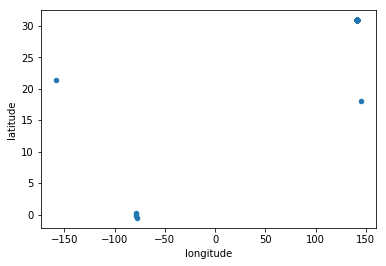

In [8]:
%matplotlib inline

df.plot('longitude', 'latitude', 'scatter')

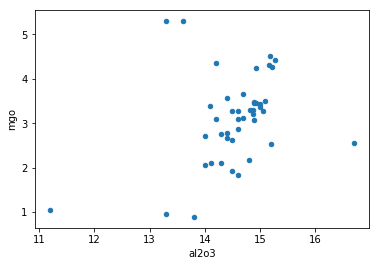

In [10]:
df.plot('al2o3', 'mgo', 'scatter')

### Schema validation against examples

In [188]:
import os
from lxml import etree, objectify
from lxml.etree import XMLSyntaxError

SOAP_SCHEMA = os.path.abspath('../earthchem/resources/soap_search_schema.xsd')
TYPE_MAPPING = {
    '{{{}}}complexType'.format(self.ns['xs']): 'complex',
    '{{{}}}simpleType'.format(self.ns['xs']): 'simple',
    '{{{}}}string'.format(self.ns['xs']): 'string',
    'xs:string': 'string'
}

def get_type(elem):
    """ Get the data type for an XML element
    """    
    # First check the attributes
    attrtype = elem.get('type')
    if attrtype is not None:
        return TYPE_MAPPING[attrtype]

    # Ok so there's probably some children to check then
    # If we have children then we can have a complex type or a simple type
    # If an xs:complexType we make a dict, if xs:simpleType we expect a string
    for child in elem.getchildren():
        try:
            return TYPE_MAPPING[child.tag]
        except KeyError:
            continue
    
    # If we're here we dont' know what to do
    raise ValueError("Can't parse type for element {}".format(elem))

class QueryElement(dict):
    
    """ Class to generate a query element for each 
        part of the query
        
        This generates fairly kludgy validators against 
        the SOAP search schema which will let us check that
        a query is well-formed.
        
        Parameters:
            name - the name of the query element.
                Should be the same as in the XML soap
                search schema.
    """
    
    ns = {"xs": "http://www.w3.org/2001/XMLSchema"}
    
    def __init__(self, name):
        self.name = name.lower()
        self.xmlname = name
        
        # Storage slots for caching
        self._tree = None
        
        # Find the element for the given name
        query = "//xs:element[@name='{}']".format(self.xmlname)
        self.root = self.xpath(query)[0]
        self.dtype = get_type(self.root)
        if self.dtype == 'complex':
            print('getting valid keys')
            print('getting valid values')
        elif self.dtype == 'simple':
            print('getting valid values')
        else:
            print('Query is just a string')
    
    @property
    def tree(self):
        "Return the XML tree for the SOAP schema"
        # Return from cache if we already have it
        if self._tree is not None:
            return self._tree
        
        # Otherwise just make a new tree
        with open(soap_schema, 'r') as src:
            self._tree = etree.parse(src)
        
        return self._tree
    
    def xpath(self, query):
        "Run an xpath query against our schema"
        return self.tree.xpath(query, namespaces=self.ns)
    

In [189]:
self = QueryElement('Reference')

getting valid keys
getting valid values


In [190]:
type_mapping

{'{http://www.w3.org/2001/XMLSchema}complexType': 'complex',
 '{http://www.w3.org/2001/XMLSchema}simpleType': 'simple',
 '{http://www.w3.org/2001/XMLSchema}string': 'string'}

In [191]:
get_type(self.root)

'complex'

In [285]:
def complex_validator(elem):
    """ Construct a validator for an xs:complexType
    """
    # Pull together keys and validators for each key
    validators = {}
    for attr in elem.xpath('./xs:complexType/xs:attribute', namespaces=self.ns):
        # Decide what type of validator we need based on attribute type
        attrtype = get_type(attr)
        if attrtype == 'string':
            # We accept anything for strings
            validators[name] = string_validator(attr)
            
        elif attrtype == 'simple':
            # For simple types there's a restriction on values
            print('constructing simple validator')
            validators[attr.get('name')] = construct_simple_validator(attr)
            
        elif attrtype == 'complex':
            validators[attr.get('name')] = construct_complex_validator(attr)
        
    # Construct a validator function
    name = elem.get('name')
    def _validator(obj):
        if type(obj) != dict:
            raise ValueError('I expected a dict for parameter {} - got a {} instead ({})'.format(name, type(obj), obj))
        
        # Check keys and values against schema
        for key, value in obj.items():
            try:
                if not validators
    
    return _validator

def simple_validator(elem):
    """ Construct a validator for an xs:simpleType - these are normally values
        with particular restrictions
    """
    # Construct a validator that checks values against known ok values
    name = elem.get('name')
    def _validator(obj):
        if type(obj) != dict:
            raise ValueError('I expected a str for parameter {} - got a {} instead ({})'.format(name, type(obj), obj))

    # Return the validation function
    return _validator

def string_validator(elem):
    """ String validator for objects - validates any string it's passed
    """
    # Construct a validator that just checks that we have a string
    name = elem.get('name')
    def _validator(obj):
        if type(obj) != str:
            raise ValueError('I expected a string for parameter {} - got a {} instead ({})'.format(elem, type(obj), obj))
        return True
    
    # Return the validation function
    return _validator

validator_mapping = {
    'string': string_validator,
    'complex': complex_validator,
    'simple': simple_validator
}

def validate(dict_like, validators):
    for key, value in dict_like.items():
        try:
            if not validators[key](value):
                raise ValueError
        except KeyError:
            print('Invalid key {}, valid keys are {}'.format(key, validators.keys()))
        print(validators[key](value))

In [286]:
validators = construct_complex_validator(self.root)

In [287]:
validators.keys()

dict_keys(['author', 'title', 'journal', 'doi', 'minpubyear', 'maxpubyear', 'exactpubyear'])

In [288]:
validate({'author': 'Barnes', 'title': 'foo', 'doi': ['http://dx.doi.org/asdfho.sdfl']}, validators)

True
True


ValueError: I expected a string for parameter doi - got a <class 'list'> instead (['http://dx.doi.org/asdfho.sdfl'])

In [289]:
a = ['foo']
type(a)

list

In [276]:
a = 'foo'
type(a)

str